# Example for the Metro Interstate Traffic Volume Dataset

https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume

In [1]:
%env CUDA_VISIBLE_DEVICES=1

env: CUDA_VISIBLE_DEVICES=1


In [2]:
import dill

import pandas as pd
import numpy as np

from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen

import tensorflow as tf

from tensorflow.keras import datasets, layers, models

from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt
from IPython.display import clear_output

In [3]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

In [4]:
class PlotLosses(tf.keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label='loss')
        plt.plot(self.x, self.val_losses, label='val_loss')
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

In [5]:
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/00492/Metro_Interstate_Traffic_Volume.csv.gz'

resp = urlopen(url)

In [6]:
import gzip
with gzip.open(BytesIO(resp.read()), 'rb') as f:
    df = pd.read_csv(f)

In [7]:
df

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,2012-10-02 09:00:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,2012-10-02 10:00:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 11:00:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,2012-10-02 12:00:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,2012-10-02 13:00:00,4918
...,...,...,...,...,...,...,...,...,...
48199,None,283.45,0.0,0.0,75,Clouds,broken clouds,2018-09-30 19:00:00,3543
48200,None,282.76,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 20:00:00,2781
48201,None,282.73,0.0,0.0,90,Thunderstorm,proximity thunderstorm,2018-09-30 21:00:00,2159
48202,None,282.09,0.0,0.0,90,Clouds,overcast clouds,2018-09-30 22:00:00,1450


In [8]:
def preprocess_data(df, normalize=True, standardize=False):
    df_temp = df.copy()
    df_temp = df_temp.dropna()
    df_temp = df_temp.reset_index()
    
    df_temp['date_time'] = pd.to_datetime(df_temp['date_time'])

    df_temp['hour'] = df_temp['date_time'].dt.hour
    df_temp['day'] = df_temp['date_time'].dt.day
    df_temp['month'] = df_temp['date_time'].dt.month
    df_temp['year'] = df_temp['date_time'].dt.year
    
    df_temp = df_temp.drop(['date_time'], axis=1)
    
    df_temp['holiday'] = df_temp['holiday'].astype('category').cat.codes
    df_temp['weather_main'] = df_temp['weather_main'].astype('category').cat.codes
    df_temp['weather_description'] = df_temp['weather_description'].astype('category').cat.codes

    min_max_dict = {}
    std_mean_dict = {}

    if normalize:

        for feature_name in df_temp.columns:
            max_value = df_temp[feature_name].max()
            min_value = df_temp[feature_name].min()

            df_temp[feature_name] = (df_temp[feature_name] - min_value) / (max_value - min_value)

            min_max_dict[feature_name] = {'max': max_value, 'min': min_value}

    elif standardize:

        for feature_name in df_temp.columns:
            std_value = df_temp[feature_name].std()
            mean_value = df_temp[feature_name].mean()

            df_temp[feature_name] = (df_temp[feature_name] - mean_value) / std_value

            std_mean_dict[feature_name] = {'std': std_value, 'mean': mean_value}
            
    return df_temp, min_max_dict, std_mean_dict

In [9]:
def create_sequences(X, y, split_feature=None, n_steps=24):
    dataset_X = []
    dataset_y = []
    
    X_temp = []
    if split_feature:
        for val in X[split_feature].unique():
            X_temp.append(X[:][X[split_feature] == val])
    else:
        X_temp.append(X)

    for x in X_temp:
        for i in range(len(x) - (n_steps + 2)):
            dataset_X.append(x.iloc[i:i + n_steps].values)
            dataset_y.append(y.iloc[i + n_steps + 1])

    return np.asarray(dataset_X), np.asarray(dataset_y)

In [10]:
df_temp = preprocess_data(df)

df_temp[0].head(10)

,index,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,hour,day,month,year
0,0.000000,0.636364,0.929726,0.0,0.0,0.40,0.1,0.648649,0.761676,0.391304,0.033333,0.818182,0.0
1,0.000021,0.636364,0.933209,0.0,0.0,0.75,0.1,0.054054,0.620330,0.434783,0.033333,0.818182,0.0
2,0.000041,0.636364,0.933918,0.0,0.0,0.90,0.1,0.513514,0.654808,0.478261,0.033333,0.818182,0.0
3,0.000062,0.636364,0.935692,0.0,0.0,0.90,0.1,0.513514,0.690385,0.521739,0.033333,0.818182,0.0
4,0.000083,0.636364,0.938949,0.0,0.0,0.75,0.1,0.054054,0.675549,0.565217,0.033333,0.818182,0.0
5,0.000104,0.636364,0.940820,0.0,0.0,0.01,0.0,0.729730,0.711676,0.608696,0.033333,0.818182,0.0
6,0.000124,0.636364,0.945496,0.0,0.0,0.01,0.0,0.729730,0.767033,0.652174,0.033333,0.818182,0.0
7,0.000145,0.636364,0.947721,0.0,0.0,0.01,0.0,0.729730,0.826236,0.695652,0.033333,0.818182,0.0
8,0.000166,0.636364,0.948625,0.0,0.0,0.20,0.1,0.108108,0.795467,0.739130,0.033333,0.818182,0.0
9,0.000187,0.636364,0.945270,0.0,0.0,0.20,0.1,0.108108,0.655220,0.782609,0.033333,0.818182,0.0


In [11]:
X = df_temp[0].drop(['traffic_volume'], axis=1)
y = df_temp[0]['traffic_volume']

data = create_sequences(X, y, n_steps=72)

In [12]:
data[0].shape

(48130, 72, 12)

In [13]:
X_temp = data[0]
y_temp = data[1]

X_train, X_test, y_train, y_test = train_test_split(X_temp, y_temp, test_size=0.2, random_state=13)

In [14]:
epochs = 150

In [15]:
cnn_model = models.Sequential()
cnn_model.add(layers.Conv1D(32, 3, activation='relu', input_shape=(72, 12)))
cnn_model.add(layers.MaxPooling1D(2))
cnn_model.add(layers.Conv1D(64, 3, activation='relu'))
cnn_model.add(layers.MaxPooling1D(2))
cnn_model.add(layers.Flatten())
cnn_model.add(layers.Dense(100, activation='relu'))
cnn_model.add(layers.Dropout(0.3))
cnn_model.add(layers.Dense(50, activation='relu'))
cnn_model.add(layers.Dropout(0.3))
cnn_model.add(layers.Dense(1))

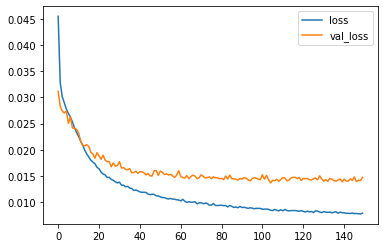

In [16]:
cnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

history = cnn_model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=0, callbacks=[plot_losses])

In [17]:
dnn_model = models.Sequential()
dnn_model.add(layers.Flatten())
dnn_model.add(layers.Dense(500, activation='relu'))
dnn_model.add(layers.Dropout(0.3))
dnn_model.add(layers.Dense(250, activation='relu'))
dnn_model.add(layers.Dropout(0.3))
dnn_model.add(layers.Dense(100, activation='relu'))
dnn_model.add(layers.Dropout(0.3))
dnn_model.add(layers.Dense(1))

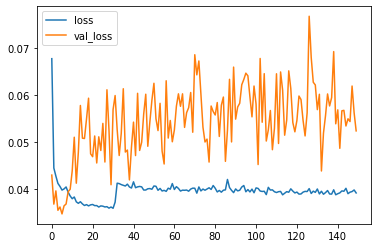

In [18]:
dnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

history = dnn_model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=0, callbacks=[plot_losses])

In [19]:
rnn_model = models.Sequential()
rnn_model.add(layers.LSTM(72, return_sequences=True))
rnn_model.add(layers.LSTM(72, return_sequences=True))
rnn_model.add(layers.Flatten())
rnn_model.add(layers.Dense(100, activation='relu'))
rnn_model.add(layers.Dropout(0.3))
rnn_model.add(layers.Dense(1))

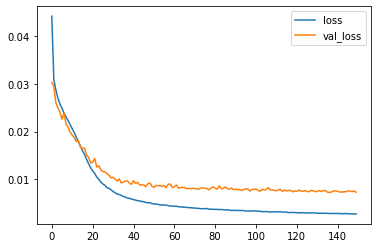

In [20]:
rnn_model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

history = rnn_model.fit(X_train, y_train, epochs=epochs, validation_data=(X_test, y_test), verbose=0, callbacks=[plot_losses])

In [21]:
dataset_test = [X_test, y_test]
dataset_test_reduced = [X_test[:10000], y_test[:10000]]

cnn_model.save('./metro_traffic_cnn_model.h5')
dnn_model.save('./metro_traffic_dnn_model.h5')
rnn_model.save('./metro_traffic_rnn_model.h5')

with open('./metro_traffic_test_data.dill', 'wb') as f:
    dill.dump(dataset_test, f)
    
with open('./metro_traffic_test_data_reduced.dill', 'wb') as f:
    dill.dump(dataset_test_reduced, f)